### Indroduction
#### This notebook consists code for the Neural Style Transfer using pre-trained CNN classifier on Video data to produce stylized video 

In [36]:
#Necessary Packages

import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils, to_categorical
from skimage.transform import resize   # for resizing images
import os
import tqdm
from tqdm import tqdm,tqdm_pandas
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras import applications,models, losses,optimizers
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_last')
import cv2
from glob import glob
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import tqdm
import cv2
from keras import applications
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D,LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import numpy as np
import keras.backend as K
import scipy as sp
from scipy.spatial import distance
from PIL import Image
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from hyperas.distributions import choice, uniform, conditional
import hyperopt
from sklearn.model_selection import train_test_split
from keras.utils import Sequence, to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from os import listdir
from pickle import dump
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,LSTM,LSTMCell
from keras.layers.merge import add
from keras.models import Model
from keras.utils import plot_model
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model
from skimage.io import imread, imshow, imread_collection, concatenate_images
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from __future__ import print_function, division
from builtins import range, input
from keras.preprocessing import image   # for preprocessing the images
from __future__ import print_function, division
from builtins import range,input
from datetime import datetime
import scipy

### Helper function for preprocessing content and style image before feed to VGG-16. We need to make sure the shape will be  (224,224),as per VGG-16 standard input format.

In [35]:
def load_preprocess_img(p,shape = None):
    Img = image.load_img(p, target_size=shape)
    X = image.img_to_array(Img)
    X = np.expand_dims(X,axis=0)    
    X = preprocess_input(X)
    return X

def preprocess_img(frame,shape = None):
    X = np.expand_dims(frame,axis=0)    
    X = preprocess_input(X.astype(('float64')))
    return X
    

#Loading style image
    
style_img = load_preprocess_img(p = 'D:/data_science/udemy/machine_learning_examples-master/cnn_class2/styles/starrynight.jpg', shape=(224,224))
batch_shape = style_img.shape
shape = style_img.shape[1:]
shape

(224, 224, 3)

### Some helper functions:

#### a) vgg_avg_pooling customizes keras standard VGG16. Here we want to account for features across the entire image so get rid of the maxpool which throws away information

#### b) vgg_cutoff freezes the output(activation map)layer of earlier defined vgg_avg_pool model.there are 13 convolutions in total we can pick any of deeper layer as the "output" of our content model

#### c) gram_matrix defines calculation of Gram matrix for network feature maps

#### d) After gram_matrix calculation we will use style_loss function to total style loss of the style network.

#### e) unpreprocess and f) scale(optional) are to restore/modify the image pixel values generated from VGG-16

In [41]:
shape = (224,224,3)

#Content model define
def vgg_avg_pooling(shape):
    vgg = VGG16(input_shape=shape,weights='imagenet',include_top=False)
    model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
        # replace it with average pooling    
            model.add(AveragePooling2D())
        else:
            model.add(layer)
    return model   

def vgg_cutoff(shape,num_conv):
    if num_conv<1|num_conv>13:
        print('Error layer must be with in [1,13]')
    model = vgg_avg_pooling(shape)
    new_model = Sequential()
    n=0
    for layer in model.layers:
        new_model.add(layer)
        if layer.__class__ == Conv2D:
            n+=1
        if n >= num_conv:
            break
    return new_model

#Style loss comutation graph

def gram_matrix(img):
    # input is (H, W, C) (C = # feature maps)
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img,(2,0,1)))
    # now, calculate the gram matrix
    # gram = XX^T / N
    gram_mat = K.dot(X,K.transpose(X))/img.get_shape().num_elements()
    return gram_mat 

def style_loss(y,t):
    return K.mean(K.square(gram_matrix(y)-gram_matrix(t)))

def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale(x):
    x = x-x.min()
    x=x/x.max()
    return x

#### This code block describes network and necessary computation for style image.We don't apply vgg_cutoff function here as the idea is to form a multi-output model combining shallow and deep conv layers to calculate style loss for style representation.

In [46]:
#loading,processing and defining multi_output_model and style loss computation of style image

#Style image load and VGG model load.
path = 'D:/data_science/udemy/machine_learning_examples-master/cnn_class2/styles/starrynight.jpg'
img = image.load_img(path)
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)    
x = preprocess_input(x)
    #shape
batch_shape = x.shape
shape = x.shape[1:]
vgg = vgg_avg_pooling(shape)

#Define multi-output model
symb_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
multi_output_model = Model(vgg.input, symb_conv_outputs)
symb_layer_out = [K.variable(y) for y in multi_output_model.predict(x)]

#Conv layer weight matrix
weights = [0.2,0.4,0.3,0.5,0.2]    
loss=0
#Total style loss
for symb,actual,w in zip(symb_conv_outputs,symb_layer_out,weights):
    loss += w * style_loss(symb[0],actual[0])
    
#gradients which are needed by the optimizer    
grad = K.gradients(loss,multi_output_model.input)
get_loss_grad = K.Function(inputs=[multi_output_model.input], outputs=[loss] + grad)

#Scipy's minimizer function(fmin_l_bfgs_b) allows us to pass back function value f(x) and 
#its gradient f'(x), which we calculated in earlier step. 
#However, we need to unroll the input to minimizer function in1-D array format and both loss and gradient must be np.float64.

def get_loss_grad_wrapper(x_vec):
    l,g = get_loss_grad([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)    

### L-BFGS optimizer to minimize overall network loss. Here we directly feed our wrapper function to calculate loss and gradient in each iteration. 

In [39]:
#Function to minimize loss
def min_loss(fn,epochs,batch_shape):
    t0 = datetime.now()
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = scipy.optimize.fmin_l_bfgs_b(func=fn,x0=x,maxfun=20)
    # bounds=[[-127, 127]]*len(x.flatten())
    #x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
        print("iter=%s, loss=%s" % (i, l))
        losses.append(l)
    print("duration:", datetime.now() - t0)
    plt.plot(losses)
    plt.show()

    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

### Put together every thing in a for loop extracting image frame and iterating individual image frame through the NST network and saving stylized images.  

iter=0, loss=808.2240600585938
iter=1, loss=501.0110778808594
iter=2, loss=348.4327392578125
iter=3, loss=262.556396484375
iter=4, loss=217.3785858154297
iter=5, loss=186.26988220214844
iter=6, loss=167.63768005371094
iter=7, loss=154.73715209960938
iter=8, loss=145.7502899169922
iter=9, loss=138.62655639648438
iter=10, loss=132.93226623535156
iter=11, loss=128.34071350097656
iter=12, loss=124.35161590576172
iter=13, loss=120.54840850830078
iter=14, loss=117.12924194335938
iter=15, loss=113.95858001708984
iter=16, loss=110.72100830078125
iter=17, loss=107.96934509277344
iter=18, loss=105.46459197998047
iter=19, loss=103.3429946899414
iter=20, loss=101.42585754394531
iter=21, loss=99.64859771728516
iter=22, loss=98.08206176757812
iter=23, loss=96.64752960205078
iter=24, loss=95.35696411132812
iter=25, loss=94.19092559814453
iter=26, loss=93.10047149658203
iter=27, loss=92.1026611328125
iter=28, loss=91.09405517578125
iter=29, loss=90.1528091430664
duration: 0:08:45.909314


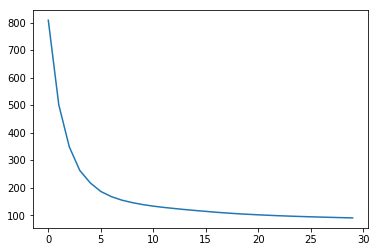

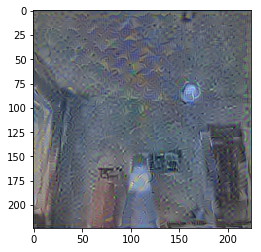

iter=0, loss=823.3698120117188
iter=1, loss=516.58837890625
iter=2, loss=364.6921081542969
iter=3, loss=277.09783935546875
iter=4, loss=222.85926818847656
iter=5, loss=193.42367553710938
iter=6, loss=173.3767852783203
iter=7, loss=159.5294189453125
iter=8, loss=148.8932647705078
iter=9, loss=140.53817749023438
iter=10, loss=134.11326599121094
iter=11, loss=129.0512237548828
iter=12, loss=124.762939453125
iter=13, loss=120.9876480102539
iter=14, loss=117.63943481445312
iter=15, loss=114.39079284667969
iter=16, loss=111.73644256591797
iter=17, loss=109.44181823730469
iter=18, loss=107.29456329345703
iter=19, loss=105.30586242675781
iter=20, loss=103.57650756835938
iter=21, loss=101.93547058105469
iter=22, loss=100.52731323242188
iter=23, loss=98.98444366455078
iter=24, loss=97.7872543334961
iter=25, loss=96.58921813964844
iter=26, loss=95.43693542480469
iter=27, loss=94.30390930175781
iter=28, loss=93.24819946289062
iter=29, loss=92.2598876953125
duration: 0:08:42.260855


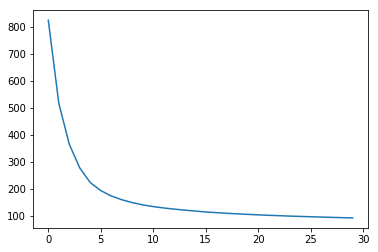

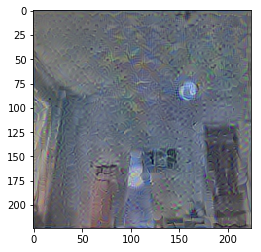

iter=0, loss=795.6062622070312
iter=1, loss=521.28662109375
iter=2, loss=377.3341979980469
iter=3, loss=291.8133239746094
iter=4, loss=238.6649169921875
iter=5, loss=204.3543243408203
iter=6, loss=180.02374267578125
iter=7, loss=163.28919982910156
iter=8, loss=151.14585876464844
iter=9, loss=141.30673217773438
iter=10, loss=134.13134765625
iter=11, loss=128.6279754638672
iter=12, loss=123.06456756591797
iter=13, loss=118.13835906982422
iter=14, loss=114.17354583740234
iter=15, loss=110.51628112792969
iter=16, loss=107.2061996459961
iter=17, loss=104.34913635253906
iter=18, loss=101.62217712402344
iter=19, loss=99.2391357421875
iter=20, loss=96.97128295898438
iter=21, loss=95.05229949951172
iter=22, loss=93.18818664550781
iter=23, loss=91.468017578125
iter=24, loss=89.99121856689453
iter=25, loss=88.65784454345703
iter=26, loss=87.3694076538086
iter=27, loss=86.21910858154297
iter=28, loss=85.1983413696289
iter=29, loss=84.29403686523438
duration: 0:08:47.287528


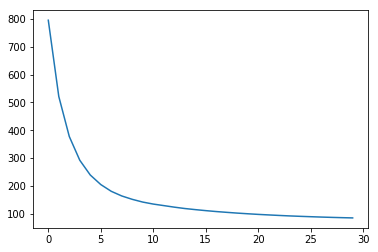

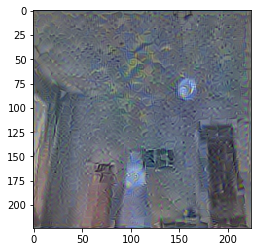

iter=0, loss=775.6024780273438
iter=1, loss=481.5634765625
iter=2, loss=352.9056396484375
iter=3, loss=273.6979675292969
iter=4, loss=228.92227172851562
iter=5, loss=197.9294891357422
iter=6, loss=175.30929565429688
iter=7, loss=158.52272033691406
iter=8, loss=145.77886962890625
iter=9, loss=135.46217346191406
iter=10, loss=127.79017639160156
iter=11, loss=121.78707122802734
iter=12, loss=116.33832550048828
iter=13, loss=111.70140838623047
iter=14, loss=107.85553741455078
iter=15, loss=104.4163589477539
iter=16, loss=101.5583267211914
iter=17, loss=99.06542205810547
iter=18, loss=96.7531509399414
iter=19, loss=94.47720336914062
iter=20, loss=92.36433410644531
iter=21, loss=90.55120849609375
iter=22, loss=88.92821502685547
iter=23, loss=87.4654541015625
iter=24, loss=86.21018981933594
iter=25, loss=84.93673706054688
iter=26, loss=83.7093276977539
iter=27, loss=82.54322814941406
iter=28, loss=81.4316635131836
iter=29, loss=80.43333435058594
duration: 0:08:38.910684


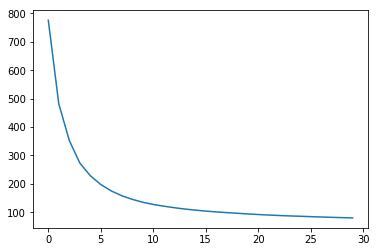

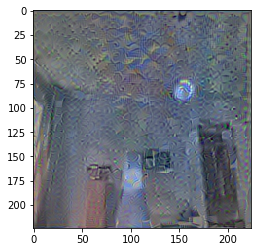

iter=0, loss=836.2938232421875
iter=1, loss=518.75732421875
iter=2, loss=353.9649963378906
iter=3, loss=270.7640686035156
iter=4, loss=229.13560485839844
iter=5, loss=201.8316650390625
iter=6, loss=182.59039306640625
iter=7, loss=168.70188903808594
iter=8, loss=157.79234313964844
iter=9, loss=149.26832580566406
iter=10, loss=142.33828735351562
iter=11, loss=136.88363647460938
iter=12, loss=131.81472778320312
iter=13, loss=127.5975112915039
iter=14, loss=123.53218841552734
iter=15, loss=120.1138916015625
iter=16, loss=116.96043395996094
iter=17, loss=114.00321197509766
iter=18, loss=111.32506561279297
iter=19, loss=108.72706604003906
iter=20, loss=106.7304458618164
iter=21, loss=104.90910339355469
iter=22, loss=103.24298858642578
iter=23, loss=101.64793395996094
iter=24, loss=100.2160873413086
iter=25, loss=98.8095474243164
iter=26, loss=97.52185821533203
iter=27, loss=96.31689453125
iter=28, loss=95.193115234375
iter=29, loss=94.20449829101562
duration: 0:08:43.451459


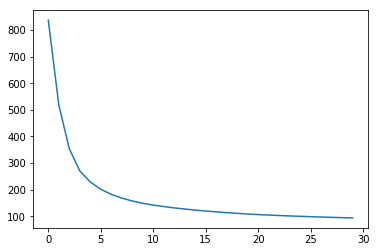

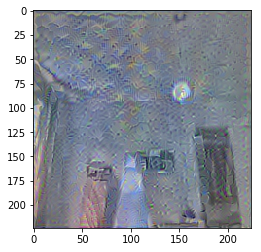

iter=0, loss=818.5353393554688
iter=1, loss=510.0567626953125
iter=2, loss=351.2812805175781
iter=3, loss=269.990234375
iter=4, loss=224.66810607910156
iter=5, loss=197.7415008544922
iter=6, loss=178.20399475097656
iter=7, loss=163.44850158691406
iter=8, loss=152.21182250976562
iter=9, loss=142.79933166503906
iter=10, loss=135.59591674804688
iter=11, loss=129.64979553222656
iter=12, loss=124.50147247314453
iter=13, loss=120.09537506103516
iter=14, loss=116.35225677490234
iter=15, loss=113.06358337402344
iter=16, loss=110.08695220947266
iter=17, loss=107.4658432006836
iter=18, loss=105.11808776855469
iter=19, loss=103.19747924804688
iter=20, loss=101.3520278930664
iter=21, loss=99.61919403076172
iter=22, loss=97.92405700683594
iter=23, loss=96.35624694824219
iter=24, loss=94.89995574951172
iter=25, loss=93.44368743896484
iter=26, loss=92.12464141845703
iter=27, loss=90.74765014648438
iter=28, loss=89.38673400878906
iter=29, loss=87.94170379638672
duration: 0:09:07.534499


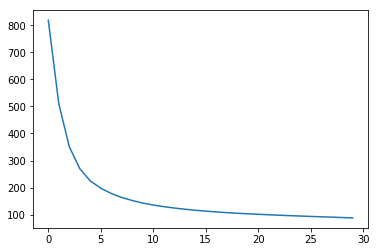

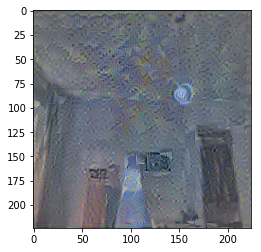

iter=0, loss=800.552490234375
iter=1, loss=483.6424560546875
iter=2, loss=346.43865966796875
iter=3, loss=273.4248046875
iter=4, loss=230.20628356933594
iter=5, loss=200.52000427246094
iter=6, loss=181.38119506835938
iter=7, loss=169.10757446289062
iter=8, loss=157.59854125976562
iter=9, loss=149.15164184570312
iter=10, loss=142.00144958496094
iter=11, loss=136.3883819580078
iter=12, loss=131.68185424804688
iter=13, loss=127.74910736083984
iter=14, loss=123.95848083496094
iter=15, loss=120.39289855957031
iter=16, loss=117.51875305175781
iter=17, loss=114.46958923339844
iter=18, loss=111.90322875976562
iter=19, loss=109.69096374511719
iter=20, loss=107.22209930419922
iter=21, loss=104.97332000732422
iter=22, loss=103.012451171875
iter=23, loss=101.00959777832031
iter=24, loss=99.15715789794922
iter=25, loss=97.47599029541016
iter=26, loss=96.00578308105469
iter=27, loss=94.41175842285156
iter=28, loss=92.96695709228516
iter=29, loss=91.49613952636719
duration: 0:09:10.473527


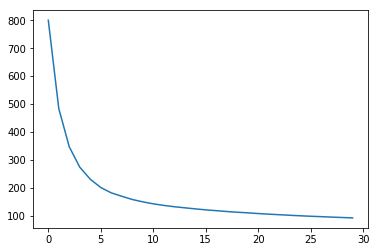

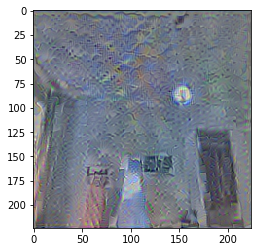

iter=0, loss=824.5455932617188
iter=1, loss=529.0371704101562
iter=2, loss=375.8811950683594
iter=3, loss=293.4884948730469
iter=4, loss=246.99658203125
iter=5, loss=215.3255157470703
iter=6, loss=194.68331909179688
iter=7, loss=179.29017639160156
iter=8, loss=166.85488891601562
iter=9, loss=157.55642700195312
iter=10, loss=148.90272521972656
iter=11, loss=142.16490173339844
iter=12, loss=136.64547729492188
iter=13, loss=131.82553100585938
iter=14, loss=127.44599151611328
iter=15, loss=123.52655792236328
iter=16, loss=120.07646942138672
iter=17, loss=116.99817657470703
iter=18, loss=114.46607971191406
iter=19, loss=111.84542846679688
iter=20, loss=109.50725555419922
iter=21, loss=107.30747985839844
iter=22, loss=105.34147644042969
iter=23, loss=103.56791687011719
iter=24, loss=101.86383819580078
iter=25, loss=100.24537658691406
iter=26, loss=98.71467590332031
iter=27, loss=97.39873504638672
iter=28, loss=95.95585632324219
iter=29, loss=94.67971801757812
duration: 0:09:04.072365


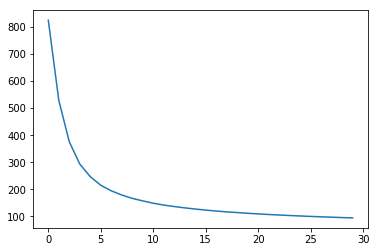

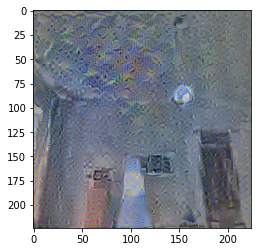

iter=0, loss=841.6306762695312
iter=1, loss=543.2915649414062
iter=2, loss=379.2109680175781
iter=3, loss=293.4291076660156
iter=4, loss=240.36036682128906
iter=5, loss=209.3540496826172
iter=6, loss=188.96810913085938
iter=7, loss=174.7304229736328
iter=8, loss=163.5308074951172
iter=9, loss=154.7305908203125
iter=10, loss=147.4515838623047
iter=11, loss=140.75506591796875
iter=12, loss=135.13409423828125
iter=13, loss=130.36328125
iter=14, loss=126.32312774658203
iter=15, loss=122.74647521972656
iter=16, loss=119.65422058105469
iter=17, loss=116.71500396728516
iter=18, loss=114.1333999633789
iter=19, loss=111.6250228881836
iter=20, loss=109.28675079345703
iter=21, loss=107.03894805908203
iter=22, loss=105.0107650756836
iter=23, loss=103.09417724609375
iter=24, loss=101.29095458984375
iter=25, loss=99.6431884765625
iter=26, loss=98.20310974121094
iter=27, loss=96.8797607421875
iter=28, loss=95.65966796875
iter=29, loss=94.41534423828125
duration: 0:08:58.244924


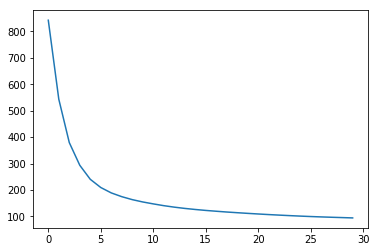

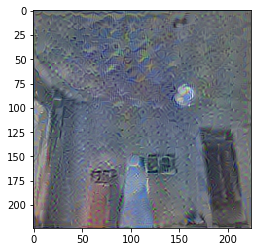

iter=0, loss=854.4900512695312
iter=1, loss=544.7496337890625
iter=2, loss=391.3147277832031
iter=3, loss=309.8877868652344
iter=4, loss=256.263427734375
iter=5, loss=224.53167724609375
iter=6, loss=204.44784545898438
iter=7, loss=189.45257568359375
iter=8, loss=178.65060424804688
iter=9, loss=169.443603515625
iter=10, loss=162.374755859375
iter=11, loss=155.9358367919922
iter=12, loss=150.32595825195312
iter=13, loss=145.46170043945312
iter=14, loss=141.64027404785156
iter=15, loss=138.19149780273438
iter=16, loss=134.9889678955078
iter=17, loss=132.282470703125
iter=18, loss=129.75245666503906
iter=19, loss=127.3551254272461
iter=20, loss=125.14326477050781
iter=21, loss=123.23651123046875
iter=22, loss=121.53044128417969
iter=23, loss=119.73562622070312
iter=24, loss=117.98933410644531
iter=25, loss=116.38058471679688
iter=26, loss=114.86598205566406
iter=27, loss=113.39397430419922
iter=28, loss=111.98816680908203
iter=29, loss=110.60088348388672
duration: 0:08:42.630705


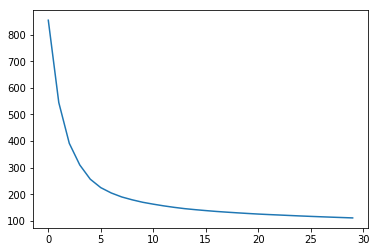

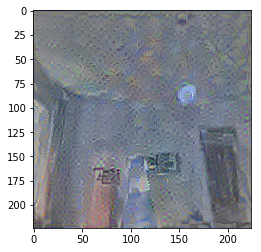

iter=0, loss=885.8399047851562
iter=1, loss=558.5172729492188
iter=2, loss=398.8174133300781
iter=3, loss=311.0792236328125
iter=4, loss=260.7664489746094
iter=5, loss=227.88192749023438
iter=6, loss=207.35169982910156
iter=7, loss=192.73504638671875
iter=8, loss=181.76718139648438
iter=9, loss=172.78118896484375
iter=10, loss=165.34371948242188
iter=11, loss=158.86187744140625
iter=12, loss=153.62342834472656
iter=13, loss=148.852783203125
iter=14, loss=144.69158935546875
iter=15, loss=141.17457580566406
iter=16, loss=138.02125549316406
iter=17, loss=135.0899658203125
iter=18, loss=132.48147583007812
iter=19, loss=130.07623291015625
iter=20, loss=127.82051849365234
iter=21, loss=125.86393737792969
iter=22, loss=123.97185516357422
iter=23, loss=122.17749786376953
iter=24, loss=120.51563262939453
iter=25, loss=119.0478515625
iter=26, loss=117.65657806396484
iter=27, loss=116.40504455566406
iter=28, loss=115.27430725097656
iter=29, loss=114.23741149902344
duration: 0:08:41.319478


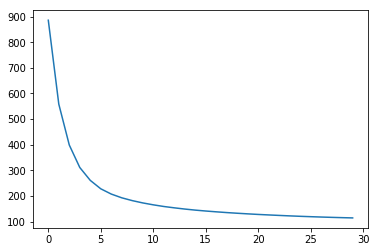

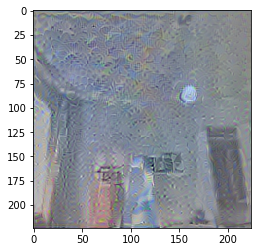

iter=0, loss=893.82763671875
iter=1, loss=567.6259765625
iter=2, loss=421.20501708984375
iter=3, loss=333.7107849121094
iter=4, loss=280.4864196777344
iter=5, loss=245.68316650390625
iter=6, loss=222.46864318847656
iter=7, loss=205.7904510498047
iter=8, loss=193.7655792236328
iter=9, loss=183.8899383544922
iter=10, loss=175.6246795654297
iter=11, loss=168.99192810058594
iter=12, loss=164.03573608398438
iter=13, loss=159.09725952148438
iter=14, loss=155.02816772460938
iter=15, loss=151.19232177734375
iter=16, loss=147.6639862060547
iter=17, loss=144.21270751953125
iter=18, loss=141.21949768066406
iter=19, loss=138.79693603515625
iter=20, loss=136.38389587402344
iter=21, loss=134.21971130371094
iter=22, loss=132.3292999267578
iter=23, loss=130.3260040283203
iter=24, loss=128.41087341308594
iter=25, loss=126.638671875
iter=26, loss=125.05402374267578
iter=27, loss=123.48983764648438
iter=28, loss=122.09465789794922
iter=29, loss=120.59687805175781
duration: 0:08:41.703214


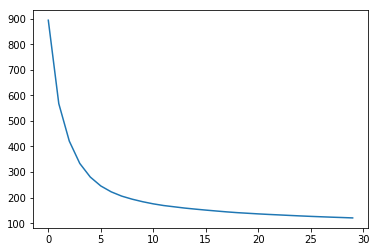

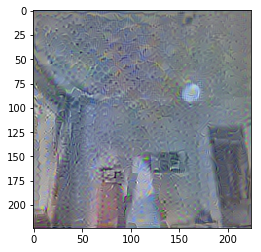

iter=0, loss=885.5228271484375
iter=1, loss=559.0237426757812
iter=2, loss=398.133544921875
iter=3, loss=314.44537353515625
iter=4, loss=265.7863464355469
iter=5, loss=234.188232421875
iter=6, loss=213.79103088378906
iter=7, loss=199.06024169921875
iter=8, loss=187.90765380859375
iter=9, loss=177.9036102294922
iter=10, loss=170.1693878173828
iter=11, loss=164.28297424316406
iter=12, loss=158.81886291503906
iter=13, loss=153.6927490234375
iter=14, loss=149.3127899169922
iter=15, loss=145.0120849609375
iter=16, loss=141.05223083496094
iter=17, loss=137.5614471435547
iter=18, loss=134.4782257080078
iter=19, loss=131.74783325195312
iter=20, loss=129.05352783203125
iter=21, loss=126.60346221923828
iter=22, loss=124.27078247070312
iter=23, loss=122.03479766845703
iter=24, loss=120.0800552368164
iter=25, loss=118.30198669433594
iter=26, loss=116.59972381591797
iter=27, loss=114.9849853515625
iter=28, loss=113.51083374023438
iter=29, loss=112.13603210449219
duration: 0:08:43.450296


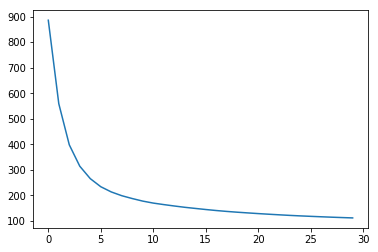

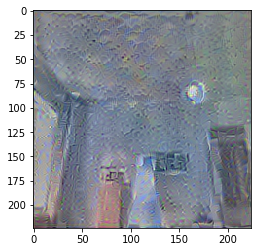

iter=0, loss=902.4639282226562
iter=1, loss=569.64404296875
iter=2, loss=397.4936218261719
iter=3, loss=306.1927185058594
iter=4, loss=259.2732238769531
iter=5, loss=230.3822479248047
iter=6, loss=207.62770080566406
iter=7, loss=192.1326904296875
iter=8, loss=179.97061157226562
iter=9, loss=171.07408142089844
iter=10, loss=164.33615112304688
iter=11, loss=158.82521057128906
iter=12, loss=154.18035888671875
iter=13, loss=150.30015563964844
iter=14, loss=146.5106201171875
iter=15, loss=143.34716796875
iter=16, loss=140.4444580078125
iter=17, loss=137.98849487304688
iter=18, loss=135.79129028320312
iter=19, loss=133.53305053710938
iter=20, loss=131.55601501464844
iter=21, loss=129.72474670410156
iter=22, loss=127.9320068359375
iter=23, loss=126.25647735595703
iter=24, loss=124.79875946044922
iter=25, loss=123.36671447753906
iter=26, loss=122.09906768798828
iter=27, loss=120.90422821044922
iter=28, loss=119.79003143310547
iter=29, loss=118.77710723876953
duration: 0:08:42.648229


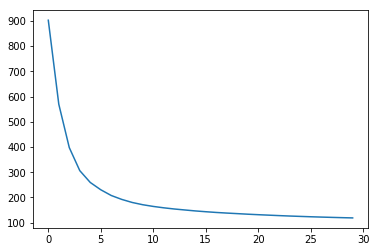

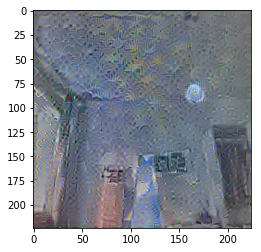

iter=0, loss=870.9495239257812
iter=1, loss=555.7233276367188
iter=2, loss=398.8087463378906
iter=3, loss=311.61614990234375
iter=4, loss=260.3778991699219
iter=5, loss=227.5380096435547
iter=6, loss=206.76956176757812
iter=7, loss=191.36489868164062
iter=8, loss=180.6184539794922
iter=9, loss=172.01962280273438
iter=10, loss=164.7553253173828
iter=11, loss=158.13485717773438
iter=12, loss=152.1605682373047
iter=13, loss=147.31768798828125
iter=14, loss=143.24746704101562
iter=15, loss=139.67138671875
iter=16, loss=136.54217529296875
iter=17, loss=133.51246643066406
iter=18, loss=130.71017456054688
iter=19, loss=128.1704864501953
iter=20, loss=125.85027313232422
iter=21, loss=123.77142333984375
iter=22, loss=121.90726470947266
iter=23, loss=120.24613189697266
iter=24, loss=118.62010192871094
iter=25, loss=117.12315368652344
iter=26, loss=115.66924285888672
iter=27, loss=114.39204406738281
iter=28, loss=113.184814453125
iter=29, loss=111.99301147460938
duration: 0:08:42.883308


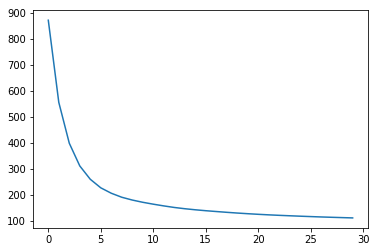

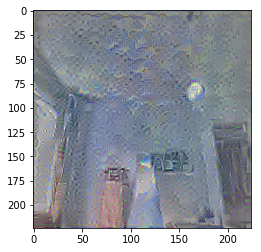

iter=0, loss=917.1954956054688
iter=1, loss=572.0939331054688
iter=2, loss=407.2261657714844
iter=3, loss=322.4762878417969
iter=4, loss=273.3442077636719
iter=5, loss=243.54190063476562
iter=6, loss=222.01841735839844
iter=7, loss=206.88125610351562
iter=8, loss=195.08082580566406
iter=9, loss=186.78807067871094
iter=10, loss=180.24639892578125
iter=11, loss=174.68263244628906
iter=12, loss=169.20819091796875
iter=13, loss=164.6461181640625
iter=14, loss=160.94332885742188
iter=15, loss=157.67227172851562
iter=16, loss=154.08740234375
iter=17, loss=150.9110565185547
iter=18, loss=148.0502471923828
iter=19, loss=145.2503204345703
iter=20, loss=142.56466674804688
iter=21, loss=140.0293731689453
iter=22, loss=137.6338653564453
iter=23, loss=135.3551025390625
iter=24, loss=133.0600128173828
iter=25, loss=130.855224609375
iter=26, loss=129.11033630371094
iter=27, loss=127.44741821289062
iter=28, loss=125.51516723632812
iter=29, loss=123.83255767822266
duration: 0:08:44.208044


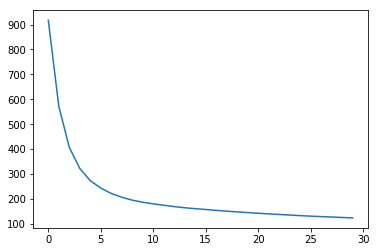

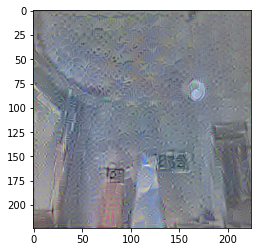

iter=0, loss=853.2815551757812
iter=1, loss=544.2738037109375
iter=2, loss=398.7732238769531
iter=3, loss=322.7582702636719
iter=4, loss=275.36920166015625
iter=5, loss=243.5168914794922
iter=6, loss=221.016845703125
iter=7, loss=205.71072387695312
iter=8, loss=193.58486938476562
iter=9, loss=184.60484313964844
iter=10, loss=177.18455505371094
iter=11, loss=170.65264892578125
iter=12, loss=164.90419006347656
iter=13, loss=160.01531982421875
iter=14, loss=155.8872528076172
iter=15, loss=152.5059356689453
iter=16, loss=149.08433532714844
iter=17, loss=145.91709899902344
iter=18, loss=143.0287322998047
iter=19, loss=140.48182678222656
iter=20, loss=138.24642944335938
iter=21, loss=135.96922302246094
iter=22, loss=133.9608917236328
iter=23, loss=132.17774963378906
iter=24, loss=130.51693725585938
iter=25, loss=128.98971557617188
iter=26, loss=127.24152374267578
iter=27, loss=125.60493469238281
iter=28, loss=123.98020935058594
iter=29, loss=122.48565673828125
duration: 0:08:44.580606


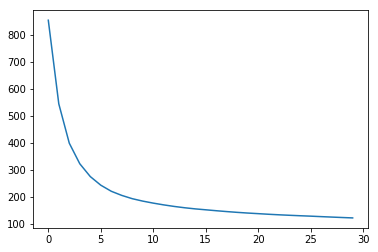

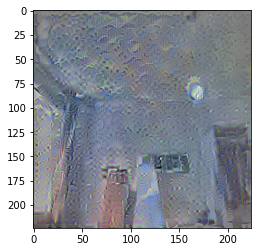

iter=0, loss=858.762451171875
iter=1, loss=542.3616943359375
iter=2, loss=385.1886291503906
iter=3, loss=297.33831787109375
iter=4, loss=250.2646942138672
iter=5, loss=220.94735717773438
iter=6, loss=199.77284240722656
iter=7, loss=184.55984497070312
iter=8, loss=173.53570556640625
iter=9, loss=164.5994110107422
iter=10, loss=157.7704315185547
iter=11, loss=151.86532592773438
iter=12, loss=146.51177978515625
iter=13, loss=142.16786193847656
iter=14, loss=138.27574157714844
iter=15, loss=134.88018798828125
iter=16, loss=131.98707580566406
iter=17, loss=129.47279357910156
iter=18, loss=127.052734375
iter=19, loss=124.83362579345703
iter=20, loss=122.68366241455078
iter=21, loss=120.85453796386719
iter=22, loss=119.00245666503906
iter=23, loss=117.27407836914062
iter=24, loss=115.72220611572266
iter=25, loss=114.0519027709961
iter=26, loss=112.32447814941406
iter=27, loss=110.75045013427734
iter=28, loss=109.23112487792969
iter=29, loss=107.73736572265625
duration: 0:08:44.032654


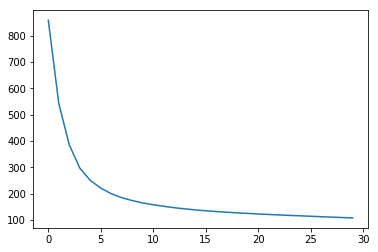

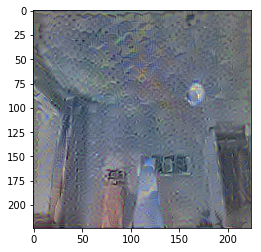

iter=0, loss=855.772705078125
iter=1, loss=545.7574462890625
iter=2, loss=401.1645812988281
iter=3, loss=314.80560302734375
iter=4, loss=263.9109191894531
iter=5, loss=231.88595581054688
iter=6, loss=209.54051208496094
iter=7, loss=191.67800903320312
iter=8, loss=178.90696716308594
iter=9, loss=169.09365844726562
iter=10, loss=161.54425048828125
iter=11, loss=155.88291931152344
iter=12, loss=150.27767944335938
iter=13, loss=145.52294921875
iter=14, loss=141.3611602783203
iter=15, loss=137.7857666015625
iter=16, loss=134.54794311523438
iter=17, loss=131.44223022460938
iter=18, loss=128.67062377929688
iter=19, loss=126.31177520751953
iter=20, loss=124.07884979248047
iter=21, loss=122.09370422363281
iter=22, loss=120.2325668334961
iter=23, loss=118.53958129882812
iter=24, loss=116.96057891845703
iter=25, loss=115.3428955078125
iter=26, loss=113.74884796142578
iter=27, loss=112.3140869140625
iter=28, loss=111.0721435546875
iter=29, loss=109.83457946777344
duration: 0:08:45.962111


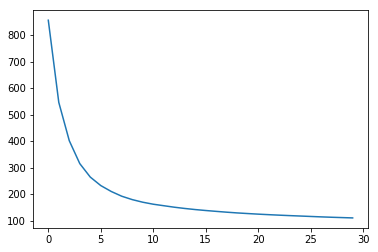

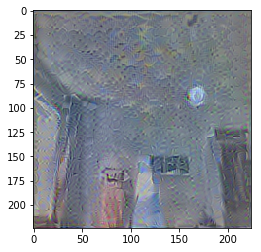

error: C:\ci\opencv_1512688052760\work\modules\imgproc\src\resize.cpp:3289: error: (-215) ssize.width > 0 && ssize.height > 0 in function cv::resize


In [28]:
import cv2
import numpy as np
 
# Create a VideoCapture object
batch_shape = style_img.shape
shape = style_img.shape[1:]
cap = cv2.VideoCapture('D:/data_science/vedio/out.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4)) 
# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")
 
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
 
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('D:/data_science/vedio/outpy.avi',cv2.VideoWriter_fourcc(*'MJPG'),20.0,(224,224))
count = 0 
while(True):
    ret, frame = cap.read()
    frame = cv2.resize(frame,(224,224))
    X = preprocess_img(frame)
    vgg = vgg_avg_pooling(shape=shape)
    content_model = Model(vgg.input,vgg.layers[13].get_output_at(1))
    content_target = content_model.predict(X)
    symb_conv_outputs = [layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')]
    multi_output_model = Model(vgg.input, symb_conv_outputs)
    symb_layer_out = [K.variable(y) for y in multi_output_model.predict(style_img)]
    weights = [0.2,0.4,0.3,0.5,0.2]
    
    loss=K.mean(K.square(content_model.output-content_target)) *4 
    for symb,actual,w in zip(symb_conv_outputs,symb_layer_out,weights):
        loss += 0.03 * w * style_loss(symb[0],actual[0])
    
    grad = K.gradients(loss,vgg.input)
    get_loss_grad = K.Function(inputs=[vgg.input], outputs=[loss] + grad)
    def get_loss_grad_wrapper(x_vec):
        l,g = get_loss_grad([x_vec.reshape(*batch_shape)])
        return l.astype(np.float64), g.flatten().astype(np.float64)
    final_img = min_loss(fn=get_loss_grad_wrapper,epochs=30,batch_shape=batch_shape)
    plt.imshow(scale(final_img))
    plt.show()
    
    
    #cv2.imshow('output',frame)
    #out.write(final_img)
    filename ="D:/data_science/vedio/style_images_2/frame%d.jpg" % count;count+=1 
    cv2.imwrite(filename, final_img)
    #if cv2.waitKey(1) & 0xFF == ord('q'):
        #break
     
    # Write the frame into the file 'output.avi'
        
 
    # Display the resulting frame    
        
  # Break the loop
    #if k == 27:
    #    break 
 
# When everything done, release the video capture and video write objects
cap.release()
out.release()
cv2.destroyAllWindows()

#### The last step is to recombine/stitch the generated image frames to form stylized video. The video generated with some pause in between.There are a few online free converters(online-convert,Wondershare UniConverter etc.),which can make the video smoother.

In [ ]:
#Converting images to video clipping

image_folder = 'D:/data_science/vedio/style_images'
video_name = 'D:/data_science/vedio/video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

## Further Improvement and Experiments:

### Following are a few strategies to improve the quality of the generated image:

#### 1) More Iterations: It is is more obvious that running the network for more iterations(approximately 1000)will reduce the overall loss and will create more clear blended images.

#### 2) Advanced CNN architecture: More often than not for NST application deeper neural networks with very advanced connection can capture high level(spatial) and detailed texture features more accurately. So it's worth trying with other superior pretrained networks like InceptionV4, GoogLeNet, Resnet-101 etc. However runtime of these networks is significantly high for NST application with thousands of iteration and require expensive computation infrastructure like powerful GPU stacks.

#### 3) Tweaking content and style loss weights: As an experiment, I tried with 4 and 0.03 as content and style loss weights respectively, mainly to focus on capturing content as much as possible(as I am running the network for only a few iterations). However, this might not be appropriate and the ideal way to find the optimal weights is through a grid search

#### 4) Tweaking layer weights for style loss: To maximize style feature capture we need to tweak weights in respective conv layers for controlling style loss computation to optimize the extraction of textures(finer textures at early layers and higher-level features at deeper layers). Again these are hyperparameters and grid search is the ideal option.